In [57]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import matplotlib.pyplot as plt

In [58]:
stock_symbol = 'AMZN'
df= yf.download(stock_symbol, start='2010-01-01', end='2025-05-01',multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [59]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6840,6.4515,6.5280,196610000


In [60]:
df['Previous Close'] = df['Close'].shift(1)
df['Price Change'] = df['Close'] - df['Previous Close']
df['High-Low'] = df['High'] - df['Low']
df['Open-Close'] = df['Open'] - df['Close']
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

In [61]:
df.dropna(inplace=True)

In [62]:
X=df[['Previous Close', 'Price Change', 'High-Low', 'Open-Close', 'MA_5', 'MA_20', 'MA_50', 'Volume']]
y=df['Close']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train.head()

,Previous Close,Price Change,High-Low,Open-Close,MA_5,MA_20,MA_50,Volume
Date,,,,,,,,
2023-10-09,127.959999,0.299995,4.029991,-2.039993,126.779999,132.111501,134.447801,38773700
2011-03-07,8.583500,-0.129499,0.292500,0.141999,8.550000,9.002400,9.035230,118658000
2017-09-11,48.294998,0.603001,0.386002,-0.174999,48.563999,48.305200,49.315370,43734000
2013-02-13,12.935000,0.538500,0.483000,-0.397000,13.075600,13.358950,13.053980,105860000
2012-03-15,9.113000,0.108500,0.206500,-0.120501,9.189900,9.091000,9.197480,83202000


In [65]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [66]:
mean_squared_error_value = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (RandomForest): {mean_squared_error_value}')

Mean Squared Error (RandomForest): 1.1665794695798888


In [67]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [68]:
mean_squared_error_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error (XGBoost): {mean_squared_error_xgb}')

Mean Squared Error (XGBoost): 1.0984002125454193


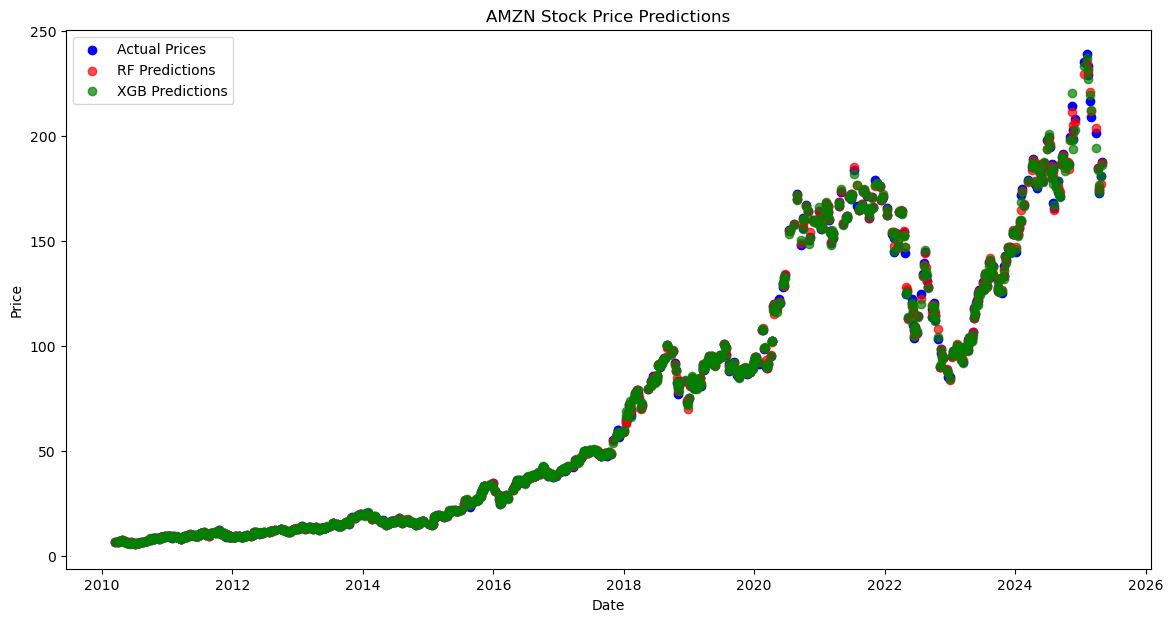

In [69]:
# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.scatter(y_test.index, y_test, label='Actual Prices', color='blue')
plt.scatter(y_test.index, y_pred_rf, label='RF Predictions', color='red', alpha=0.7)
plt.scatter(y_test.index, y_pred_xgb, label='XGB Predictions', color='green', alpha=0.7)
plt.title(f'{stock_symbol} Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [70]:
from datetime import timedelta

last_date = df.index[-1]
future_dates = [last_date + timedelta(days=1)]
future_data = pd.DataFrame(index=future_dates)

In [71]:
last_row = df.iloc[-1]
# Fill future data with last known values
for date in future_dates:
    future_data.loc[date, 'Previous Close'] = last_row['Close']
    future_data.loc[date, 'Price Change'] = 0
    future_data.loc[date, 'High-Low'] = 0
    future_data.loc[date, 'Open-Close'] = 0
    future_data.loc[date, 'MA_5'] = last_row['MA_5']
    future_data.loc[date, 'MA_20'] = last_row['MA_20']
    future_data.loc[date, 'MA_50'] = last_row['MA_50']
    future_data.loc[date, 'Volume'] = last_row['Volume']

In [72]:
rf_future_price = rf_model.predict(future_data)
xgb_future_price = xgb_model.predict(future_data)
real_stock_price = yf.download(stock_symbol, start=future_dates[0], end=future_dates[0] + timedelta(days=1),progress=False,multi_level_index=False)

print(f"Future Price Prediction (Random Forest): {rf_future_price[0]}")
print(f"Future Price Prediction (XGBoost): {xgb_future_price[0]}")
print(f"Real Stock Price: {real_stock_price['Close'].values[0]}")
print(f"Future Date: {future_dates[0].date()}")

Future Price Prediction (Random Forest): 184.7256153869629
Future Price Prediction (XGBoost): 183.5782012939453
Real Stock Price: 190.1999969482422
Future Date: 2025-05-01


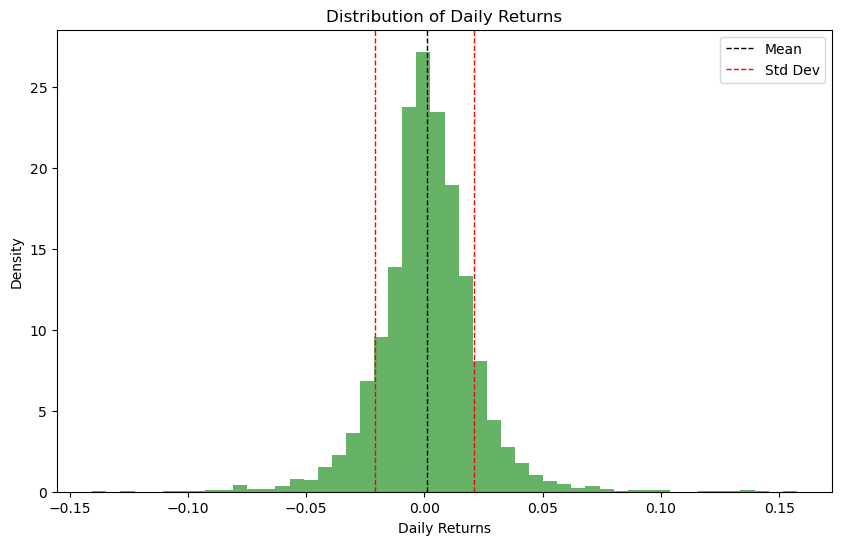

In [73]:
df['pct_change'] = df['Close'].pct_change()
#plot normal distribution of returns
plt.figure(figsize=(10, 6))
plt.hist(df['pct_change'].dropna(), bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.axvline(df['pct_change'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(df['pct_change'].std(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(-df['pct_change'].std(), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Std Dev'])
plt.show()